In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from datetime import date
from datetime import datetime
import calendar
import os
import re


from scipy import stats
from sklearn.neighbors import KernelDensity
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter

import seaborn as sns
from pathlib import Path
from tqdm import tqdm_notebook, trange, tqdm
from PIL import Image, ImageDraw
import io
import random as r

from matplotlib.widgets import Slider, Button, RadioButtons
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
# For downsampling
from sklearn.utils import resample,shuffle


from operator import itemgetter
np.random.seed(2021)

In [5]:
df_companies = pd.read_csv("./data/companies.csv")
df_payments = pd.read_csv("./data/payments.csv")
df_physicians = pd.read_csv("./physician_with_useless_features.csv")

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_physicians

,id,set,First_Name,Middle_Name,Last_Name,Name_Suffix,City,State_Phys,Zipcode,Country_Phys,Province,Primary_Specialty,License_State_1,License_State_2,License_State_3,License_State_4,License_State_5,Ownership_Interest,Total_Payments,Total_Num_Payments,Value_by_Num,Number_Transaction,Value_by_Tran,Max_Comp_ID,Max_Comp_ID_value,Max_Prod_Name,Max_Prod_Name_value,Form_of_Payment_or_Transfer_of_Value,Nature_of_Payment_or_Transfer_of_Value,City_of_Travel,State_of_Travel,Related_Product_Indicator,Form_of_Payment_or_Transfer_of_Value_occ,Nature_of_Payment_or_Transfer_of_Value_occ,City_of_Travel_occ,State_of_Travel_occ,Related_Product_Indicator_occ
0,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,0,952.93,47,20.275106,47,20.275106,197,550,PREMARIN ORALS,HARMONIC Product Family,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Celebration,FL,Covered
1,2,train,STEVEN,NaN,FRANK,NaN,TOWSON,MD,21204-6808,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Anesthesio...,MD,NaN,NaN,NaN,NaN,0,120924.92,154,785.226753,154,785.226753,601,243,Advanced Energy Hemostatic Device,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Travel and Lodging,Tampa,MA,Covered
2,3,train,THOMAS,NaN,COUCH,JR.,TROY,NY,12180-2832,UNITED STATES,NaN,Podiatric Medicine & Surgery Service Providers...,NY,NaN,NaN,NaN,NaN,0,3523.93,132,26.696439,132,26.696439,340,919,Santyl,FLEXITOUCH,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
3,4,train,CLAUDE,NaN,SU,NaN,SAVANNAH,GA,31419-1753,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Internal M...,GA,SC,AL,NaN,NaN,0,26745.61,411,65.074477,411,65.074477,377,13,ELIQUIS,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Atlanta,GA,Yes
4,5,train,ROBERT,C,SCHENCK,NaN,ALBUQUERQUE,NM,87131-0001,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Orthopaedi...,NM,NaN,NaN,NaN,NaN,0,25411.21,98,259.298061,98,259.298061,804,442,ALL ARTHREX PRODUCT LINES,NaN,Cash or cash equivalent,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,PHOENIX,AZ,Covered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5996,train,MARC,NaN,WEINSTEIN,NaN,TEMPLE TERRACE,FL,33637-0925,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Orthopaedi...,FL,NaN,NaN,NaN,NaN,0,19714.41,522,37.767069,517,38.132321,534,550,PENNSAID,CONFIDENCE,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Ocoee,FL,Covered
5996,5997,train,CHARLES,W,YOWELL,NaN,TALLAHASSEE,FL,32308-4620,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Urology,FL,SC,NaN,NaN,NaN,0,2946.90,162,18.190741,162,18.190741,69,69,Myrbetriq,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
5997,5998,train,MARK,O,GABBIE,NaN,TEXARKANA,AR,71854,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Family Med...,AR,TX,NaN,NaN,NaN,0,7870.54,648,12.145895,622,12.653601,74,75,Victoza,FARXIGA,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
5998,5999,test,KRISHNASWAMY,NaN,GAJARAJ,NaN,RANDOLPH,MA,02368-2100,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Psychiatry...,MA,NaN,NaN,NaN,NaN,0,1560.30,43,36.286047,43,36.286047,897,897,REXULTI,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Covered


In [3]:
df_companies.rename({"State":"State_Comp","Country":"Country_Comp"}, axis='columns', inplace=True)
df_physicians.rename({"State":"State_Phys","Country":"Country_Phys"}, axis='columns', inplace=True)
pd.set_option('display.max_columns', None)

In [4]:
def ownInterest(id):
    if(df_payments.query('Physician_ID==@id and Ownership_Indicator=="Yes"').shape[0]>0):
        return 1
    else:
        return 0
    
df_physicians['Ownership_Interest']=df_physicians['id'].apply(ownInterest)

KeyboardInterrupt: 

In [ ]:
#drop Ownership Indicators=yes records
df_scrap=df_payments.query('Ownership_Indicator=="Yes"', engine='python')
df_payments=pd.concat([df_payments, df_scrap]).drop_duplicates(keep=False)

In [ ]:
#Feature Engineering
def total_pay(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Total_Amount_of_Payment_USDollars.sum()

df_physicians['Total_Payments']=df_physicians['id'].apply(total_pay)

def sum_num_pay(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Number_of_Payments.sum()

df_physicians['Total_Num_Payments']=df_physicians['id'].apply(sum_num_pay)

df_physicians['Value_by_Num']=df_physicians['Total_Payments']/df_physicians['Total_Num_Payments']

def num_tran(phys_id):
    return df_payments.query('Physician_ID==@phys_id').shape[0]

df_physicians['Number_Transaction']=df_physicians['id'].apply(num_tran)

df_physicians['Value_by_Tran']=df_physicians['Total_Payments']/df_physicians['Number_Transaction']



In [ ]:
#Feature Engineering 2
def max_comp(phys_id):
    return df_payments.query('Physician_ID==@phys_id').Company_ID.value_counts().index[0]

df_physicians['Max_Comp_ID']=df_physicians['id'].apply(max_comp)


In [233]:
df_scrap=df_payments

In [ ]:
#Feature Engineering 3
def max_comp_value(phys_id):
    return df_payments.query('Physician_ID==@phys_id').sort_values('Total_Amount_of_Payment_USDollars',ascending=False).Company_ID.iloc[0]

df_physicians['Max_Comp_ID_value']=df_physicians['id'].apply(max_comp_value)

# squeeze for product name



df_scrap['index_col'] = df_scrap.index
df_scrap=pd.wide_to_long(df_scrap, stubnames='Product_Name_', i=['index_col'],j='Product_Name_Number').reset_index()
df_scrap.drop(columns=['index_col'],inplace=True)

def max_prod_occuring(phys_id):
    if(str(df_scrap.query('Physician_ID==@phys_id').Product_Name_.value_counts(dropna=False).index[0])=="nan"):
        if(df_scrap.query('Physician_ID==@phys_id').Product_Name_.value_counts(dropna=False).size<2):
            return df_scrap.query('Physician_ID==@phys_id').Product_Name_.value_counts(dropna=False).index[0]
        else:
            return df_scrap.query('Physician_ID==@phys_id').Product_Name_.value_counts(dropna=True).index[0]
    else:
        return df_scrap.query('Physician_ID==@phys_id').Product_Name_.value_counts(dropna=False).index[0]

df_physicians['Max_Prod_Name']=df_physicians['id'].apply(max_prod_occuring)

def max_prod_value(phys_id):
    return df_scrap.query('Physician_ID==@phys_id').sort_values('Total_Amount_of_Payment_USDollars',ascending=False).Product_Name_.iloc[0]

df_physicians['Max_Prod_Name_value']=df_physicians['id'].apply(max_prod_value)

df_physicians['Form_of_Payment_or_Transfer_of_Value']=0
df_physicians['Nature_of_Payment_or_Transfer_of_Value']=0
df_physicians['City_of_Travel']=0
df_physicians['State_of_Travel']=0
df_physicians['Related_Product_Indicator']=0

for i in range(df_physicians.shape[0]):
    phys=df_physicians.id.iloc[i]
    df_scrap=df_payments.query('Physician_ID==@phys').sort_values('Total_Amount_of_Payment_USDollars')
    df_physicians['Form_of_Payment_or_Transfer_of_Value'].iloc[i]=df_scrap.Form_of_Payment_or_Transfer_of_Value.iloc[0]
    df_physicians['Nature_of_Payment_or_Transfer_of_Value']=df_scrap.Nature_of_Payment_or_Transfer_of_Value.iloc[0]
    df_physicians['City_of_Travel']=df_scrap.City_of_Travel.iloc[0]
    df_physicians['State_of_Travel']=df_scrap.State_of_Travel.iloc[0]
    df_physicians['Related_Product_Indicator']=df_scrap.Related_Product_Indicator.iloc[0]


In [ ]:
df_physicians['Form_of_Payment_or_Transfer_of_Value_occ']=0
df_physicians['Nature_of_Payment_or_Transfer_of_Value_occ']=0
df_physicians['City_of_Travel_occ']=0
df_physicians['State_of_Travel_occ']=0
df_physicians['Related_Product_Indicator_occ']=0

columnsstuff=['Form_of_Payment_or_Transfer_of_Value','Nature_of_Payment_or_Transfer_of_Value','City_of_Travel','State_of_Travel','Related_Product_Indicator']

for i in range(df_physicians.shape[0]):
    phys=df_physicians.id.iloc[i]
    df_scrap=df_payments.query('Physician_ID==@phys')
    
    for col in columnsstuff:
        if(str(df_scrap[col].value_counts(dropna=False).index[0])=="nan"):
            if(df_scrap[col].value_counts(dropna=False).size<2):
                df_physicians[col+"_occ"].iloc[i] = df_scrap[col].value_counts(dropna=False).index[0]
            else:
                df_physicians[col+"_occ"].iloc[i] =  df_scrap[col].value_counts(dropna=True).index[0]
        else:
            df_physicians[col+"_occ"].iloc[i] = df_scrap[col].value_counts(dropna=False).index[0]
            
df_physicians
    

In [236]:
df_physicians.to_csv("./physician_with_useless_features.csv",index=False)

In [40]:

# scrap1= str (scrap)
# if(scrap1=="nan"):
#     print("triggered")

'PVC'

In [62]:
for col in df.columns:
    print("=====================================")
    print(col)
    print(df[col].value_counts(dropna=False))

Total_Payments
34468.28     5
172912.32    5
11461.28     5
15678.01     5
10949.51     5
            ..
3083.53      1
4427.62      1
11431.80     1
1114.76      1
2002.56      1
Name: Total_Payments, Length: 5988, dtype: int64
Max_Comp_ID_value
75      342
190     308
278     279
597     274
521     225
       ... 
2212      1
1178      1
243       1
235       1
1122      1
Name: Max_Comp_ID_value, Length: 670, dtype: int64
Max_Prod_Name
ELIQUIS                                    339
Victoza                                    300
Humira                                     293
Da Vinci Surgical System                   243
XARELTO                                    188
                                          ... 
Optics                                       1
OPD-III                                      1
JUBLIA                                       1
SURGICEL Family of Absorbable Hemostats      1
NaN                                          1
Name: Max_Prod_Name, Length: 1078, dtyp

In [11]:
df_payments.query('Physician_ID==1244').sort_values('Total_Amount_of_Payment_USDollars',ascending=False).Company_ID.iloc[0]

318

In [ ]:
df_physicians.to_csv("./modified_physician_with_features.csv",index=False)

In [ ]:
df_physicians.to_csv("./modified_physician.csv",index=False)

In [7]:
df=df_physicians

In [8]:
df

,id,set,First_Name,Middle_Name,Last_Name,Name_Suffix,City,State_Phys,Zipcode,Country_Phys,Province,Primary_Specialty,License_State_1,License_State_2,License_State_3,License_State_4,License_State_5,Ownership_Interest,Total_Payments,Total_Num_Payments,Value_by_Num,Number_Transaction,Value_by_Tran,Max_Comp_ID,Max_Comp_ID_value,Max_Prod_Name,Max_Prod_Name_value,Form_of_Payment_or_Transfer_of_Value,Nature_of_Payment_or_Transfer_of_Value,City_of_Travel,State_of_Travel,Related_Product_Indicator,Form_of_Payment_or_Transfer_of_Value_occ,Nature_of_Payment_or_Transfer_of_Value_occ,City_of_Travel_occ,State_of_Travel_occ,Related_Product_Indicator_occ
0,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,0,952.93,47,20.275106,47,20.275106,197,550,PREMARIN ORALS,HARMONIC Product Family,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Celebration,FL,Covered
1,2,train,STEVEN,NaN,FRANK,NaN,TOWSON,MD,21204-6808,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Anesthesio...,MD,NaN,NaN,NaN,NaN,0,120924.92,154,785.226753,154,785.226753,601,243,Advanced Energy Hemostatic Device,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Travel and Lodging,Tampa,MA,Covered
2,3,train,THOMAS,NaN,COUCH,JR.,TROY,NY,12180-2832,UNITED STATES,NaN,Podiatric Medicine & Surgery Service Providers...,NY,NaN,NaN,NaN,NaN,0,3523.93,132,26.696439,132,26.696439,340,919,Santyl,FLEXITOUCH,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
3,4,train,CLAUDE,NaN,SU,NaN,SAVANNAH,GA,31419-1753,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Internal M...,GA,SC,AL,NaN,NaN,0,26745.61,411,65.074477,411,65.074477,377,13,ELIQUIS,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Atlanta,GA,Yes
4,5,train,ROBERT,C,SCHENCK,NaN,ALBUQUERQUE,NM,87131-0001,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Orthopaedi...,NM,NaN,NaN,NaN,NaN,0,25411.21,98,259.298061,98,259.298061,804,442,ALL ARTHREX PRODUCT LINES,NaN,Cash or cash equivalent,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,PHOENIX,AZ,Covered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5996,train,MARC,NaN,WEINSTEIN,NaN,TEMPLE TERRACE,FL,33637-0925,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Orthopaedi...,FL,NaN,NaN,NaN,NaN,0,19714.41,522,37.767069,517,38.132321,534,550,PENNSAID,CONFIDENCE,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,Ocoee,FL,Covered
5996,5997,train,CHARLES,W,YOWELL,NaN,TALLAHASSEE,FL,32308-4620,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Urology,FL,SC,NaN,NaN,NaN,0,2946.90,162,18.190741,162,18.190741,69,69,Myrbetriq,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
5997,5998,train,MARK,O,GABBIE,NaN,TEXARKANA,AR,71854,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Family Med...,AR,TX,NaN,NaN,NaN,0,7870.54,648,12.145895,622,12.653601,74,75,Victoza,FARXIGA,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Yes
5998,5999,test,KRISHNASWAMY,NaN,GAJARAJ,NaN,RANDOLPH,MA,02368-2100,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Psychiatry...,MA,NaN,NaN,NaN,NaN,0,1560.30,43,36.286047,43,36.286047,897,897,REXULTI,NaN,In-kind items and services,Food and Beverage,NaN,NaN,No,In-kind items and services,Food and Beverage,NaN,NaN,Covered


In [9]:
df['index_col'] = df.index
df=pd.wide_to_long(df, stubnames='License_State_', i=['index_col'],j='License_State_Number').reset_index()
df.drop(columns=['index_col'],inplace=True)

In [10]:
df.columns

Index(['License_State_Number', 'Nature_of_Payment_or_Transfer_of_Value_occ',
       'Zipcode', 'Ownership_Interest',
       'Nature_of_Payment_or_Transfer_of_Value', 'Max_Prod_Name',
       'Middle_Name', 'State_Phys', 'State_of_Travel', 'Number_Transaction',
       'Form_of_Payment_or_Transfer_of_Value', 'Related_Product_Indicator',
       'set', 'Related_Product_Indicator_occ', 'Max_Prod_Name_value',
       'City_of_Travel', 'State_of_Travel_occ', 'Name_Suffix',
       'Form_of_Payment_or_Transfer_of_Value_occ', 'Value_by_Tran',
       'Max_Comp_ID', 'Max_Comp_ID_value', 'First_Name', 'City',
       'Value_by_Num', 'id', 'Total_Payments', 'Total_Num_Payments',
       'Province', 'City_of_Travel_occ', 'Last_Name', 'Primary_Specialty',
       'Country_Phys', 'License_State_'],
      dtype='object')

In [11]:
# 'License_State_Number'
columnsDrop=['First_Name', 'Middle_Name', 'Last_Name', 'Name_Suffix','Province',
            'Country_Phys', 'License_State_Number']
columns_encode=['Nature_of_Payment_or_Transfer_of_Value_occ','Form_of_Payment_or_Transfer_of_Value_occ',
            'Related_Product_Indicator_occ','Form_of_Payment_or_Transfer_of_Value','City_of_Travel_occ',
                'State_of_Travel_occ','License_State_','Max_Prod_Name_value','City', 'State_Phys', 'Zipcode','Primary_Specialty','Max_Prod_Name','Nature_of_Payment_or_Transfer_of_Value', 'City_of_Travel','State_of_Travel', 'Related_Product_Indicator',]

# [('License_State_', 0.0411224157098665),
#  ('State_Phys', 0.04868893801899689),
#  ('City', 0.074774525605595),
#  ('Zipcode', 0.07724941927465524),
#  ('Value_by_Num', 0.08004534470216931),
#  ('Total_Payments', 0.08097371657841908),
#  ('Max_Comp_ID', 0.08098239874692156),
#  ('Value_by_Tran', 0.08621184031187747),
#  ('Number_Transaction', 0.09229035768225724),
#  ('Total_Num_Payments', 0.09465316321179255),
#  ('Primary_Specialty', 0.2430078801574491)]

df.drop(columns=columnsDrop, inplace=True)

In [12]:
df.dropna(subset=['License_State_'],inplace=True)

In [13]:

df.columns

Index(['Nature_of_Payment_or_Transfer_of_Value_occ', 'Zipcode',
       'Ownership_Interest', 'Nature_of_Payment_or_Transfer_of_Value',
       'Max_Prod_Name', 'State_Phys', 'State_of_Travel', 'Number_Transaction',
       'Form_of_Payment_or_Transfer_of_Value', 'Related_Product_Indicator',
       'set', 'Related_Product_Indicator_occ', 'Max_Prod_Name_value',
       'City_of_Travel', 'State_of_Travel_occ',
       'Form_of_Payment_or_Transfer_of_Value_occ', 'Value_by_Tran',
       'Max_Comp_ID', 'Max_Comp_ID_value', 'City', 'Value_by_Num', 'id',
       'Total_Payments', 'Total_Num_Payments', 'City_of_Travel_occ',
       'Primary_Specialty', 'License_State_'],
      dtype='object')

In [14]:

# df['Max_Prod_Name']=df['Max_Prod_Name'].astype('category')
# df['Max_Prod_Name_value']=df['Max_Prod_Name_value'].astype('category')
# name_list = pd.unique(df[['Max_Prod_Name', 'Max_Prod_Name_value']].values.ravel('K'))
# # name_list = np.delete(name_list,np.where(name_list=="nan"))
# name_list_dict = {}
# int_code=int(1)
# for name in name_list:
#     name_list_dict.update({name:int_code})
#     int_code+=1
# name_list_dict.update({"nan":-1})

# def product_encode(product_name):
#     return name_list_dict.get(product_name)

# df['Max_Prod_Name'] = df['Max_Prod_Name'].apply(product_encode)
# df['Max_Prod_Name_value'] = df['Max_Prod_Name_value'].apply(product_encode)

for column in columns_encode:
    df[column]=df[column].astype('category')
    df[column]=df[column].cat.codes

In [15]:
df

,Nature_of_Payment_or_Transfer_of_Value_occ,Zipcode,Ownership_Interest,Nature_of_Payment_or_Transfer_of_Value,Max_Prod_Name,State_Phys,State_of_Travel,Number_Transaction,Form_of_Payment_or_Transfer_of_Value,Related_Product_Indicator,set,Related_Product_Indicator_occ,Max_Prod_Name_value,City_of_Travel,State_of_Travel_occ,Form_of_Payment_or_Transfer_of_Value_occ,Value_by_Tran,Max_Comp_ID,Max_Comp_ID_value,City,Value_by_Num,id,Total_Payments,Total_Num_Payments,City_of_Travel_occ,Primary_Specialty,License_State_
0,3,2327,0,0,706,9,-1,47,1,0,train,0,389,-1,8,1,20.275106,197,550,537,20.275106,1,952.93,47,93,57,9
1,8,1228,0,0,77,20,-1,154,1,0,train,0,-1,-1,18,1,785.226753,601,243,1648,785.226753,2,120924.92,154,482,3,22
2,3,783,0,0,856,34,-1,132,1,0,train,4,347,-1,-1,1,26.696439,340,919,1655,26.696439,3,3523.93,132,-1,160,36
3,3,1855,0,0,284,10,-1,411,1,0,train,4,-1,-1,9,1,65.074477,377,13,1467,65.074477,4,26745.61,411,24,30,11
4,3,4743,0,0,29,32,-1,98,0,0,train,0,-1,-1,2,1,259.298061,804,442,19,259.298061,5,25411.21,98,352,74,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29109,3,3235,0,0,44,22,-1,529,1,0,train,4,785,-1,21,1,29.637070,334,152,1268,28.046530,5110,15678.01,559,370,44,40
29529,3,4662,0,0,525,3,-1,557,1,0,train,4,625,-1,22,1,252.614776,597,521,1475,246.421068,5530,140706.43,571,288,31,49
29564,3,5008,0,0,255,4,-1,267,1,0,train,4,142,-1,3,1,117.482397,597,44,1346,112.833813,5565,31367.80,278,249,140,51
29813,3,3503,0,0,810,14,-1,673,0,0,train,4,-1,-1,41,0,591.281634,1069,1069,282,591.281634,5814,397932.54,673,97,127,13


In [201]:
df.Ownership_Interest.value_counts()

0    5700
1     300
Name: Ownership_Interest, dtype: int64

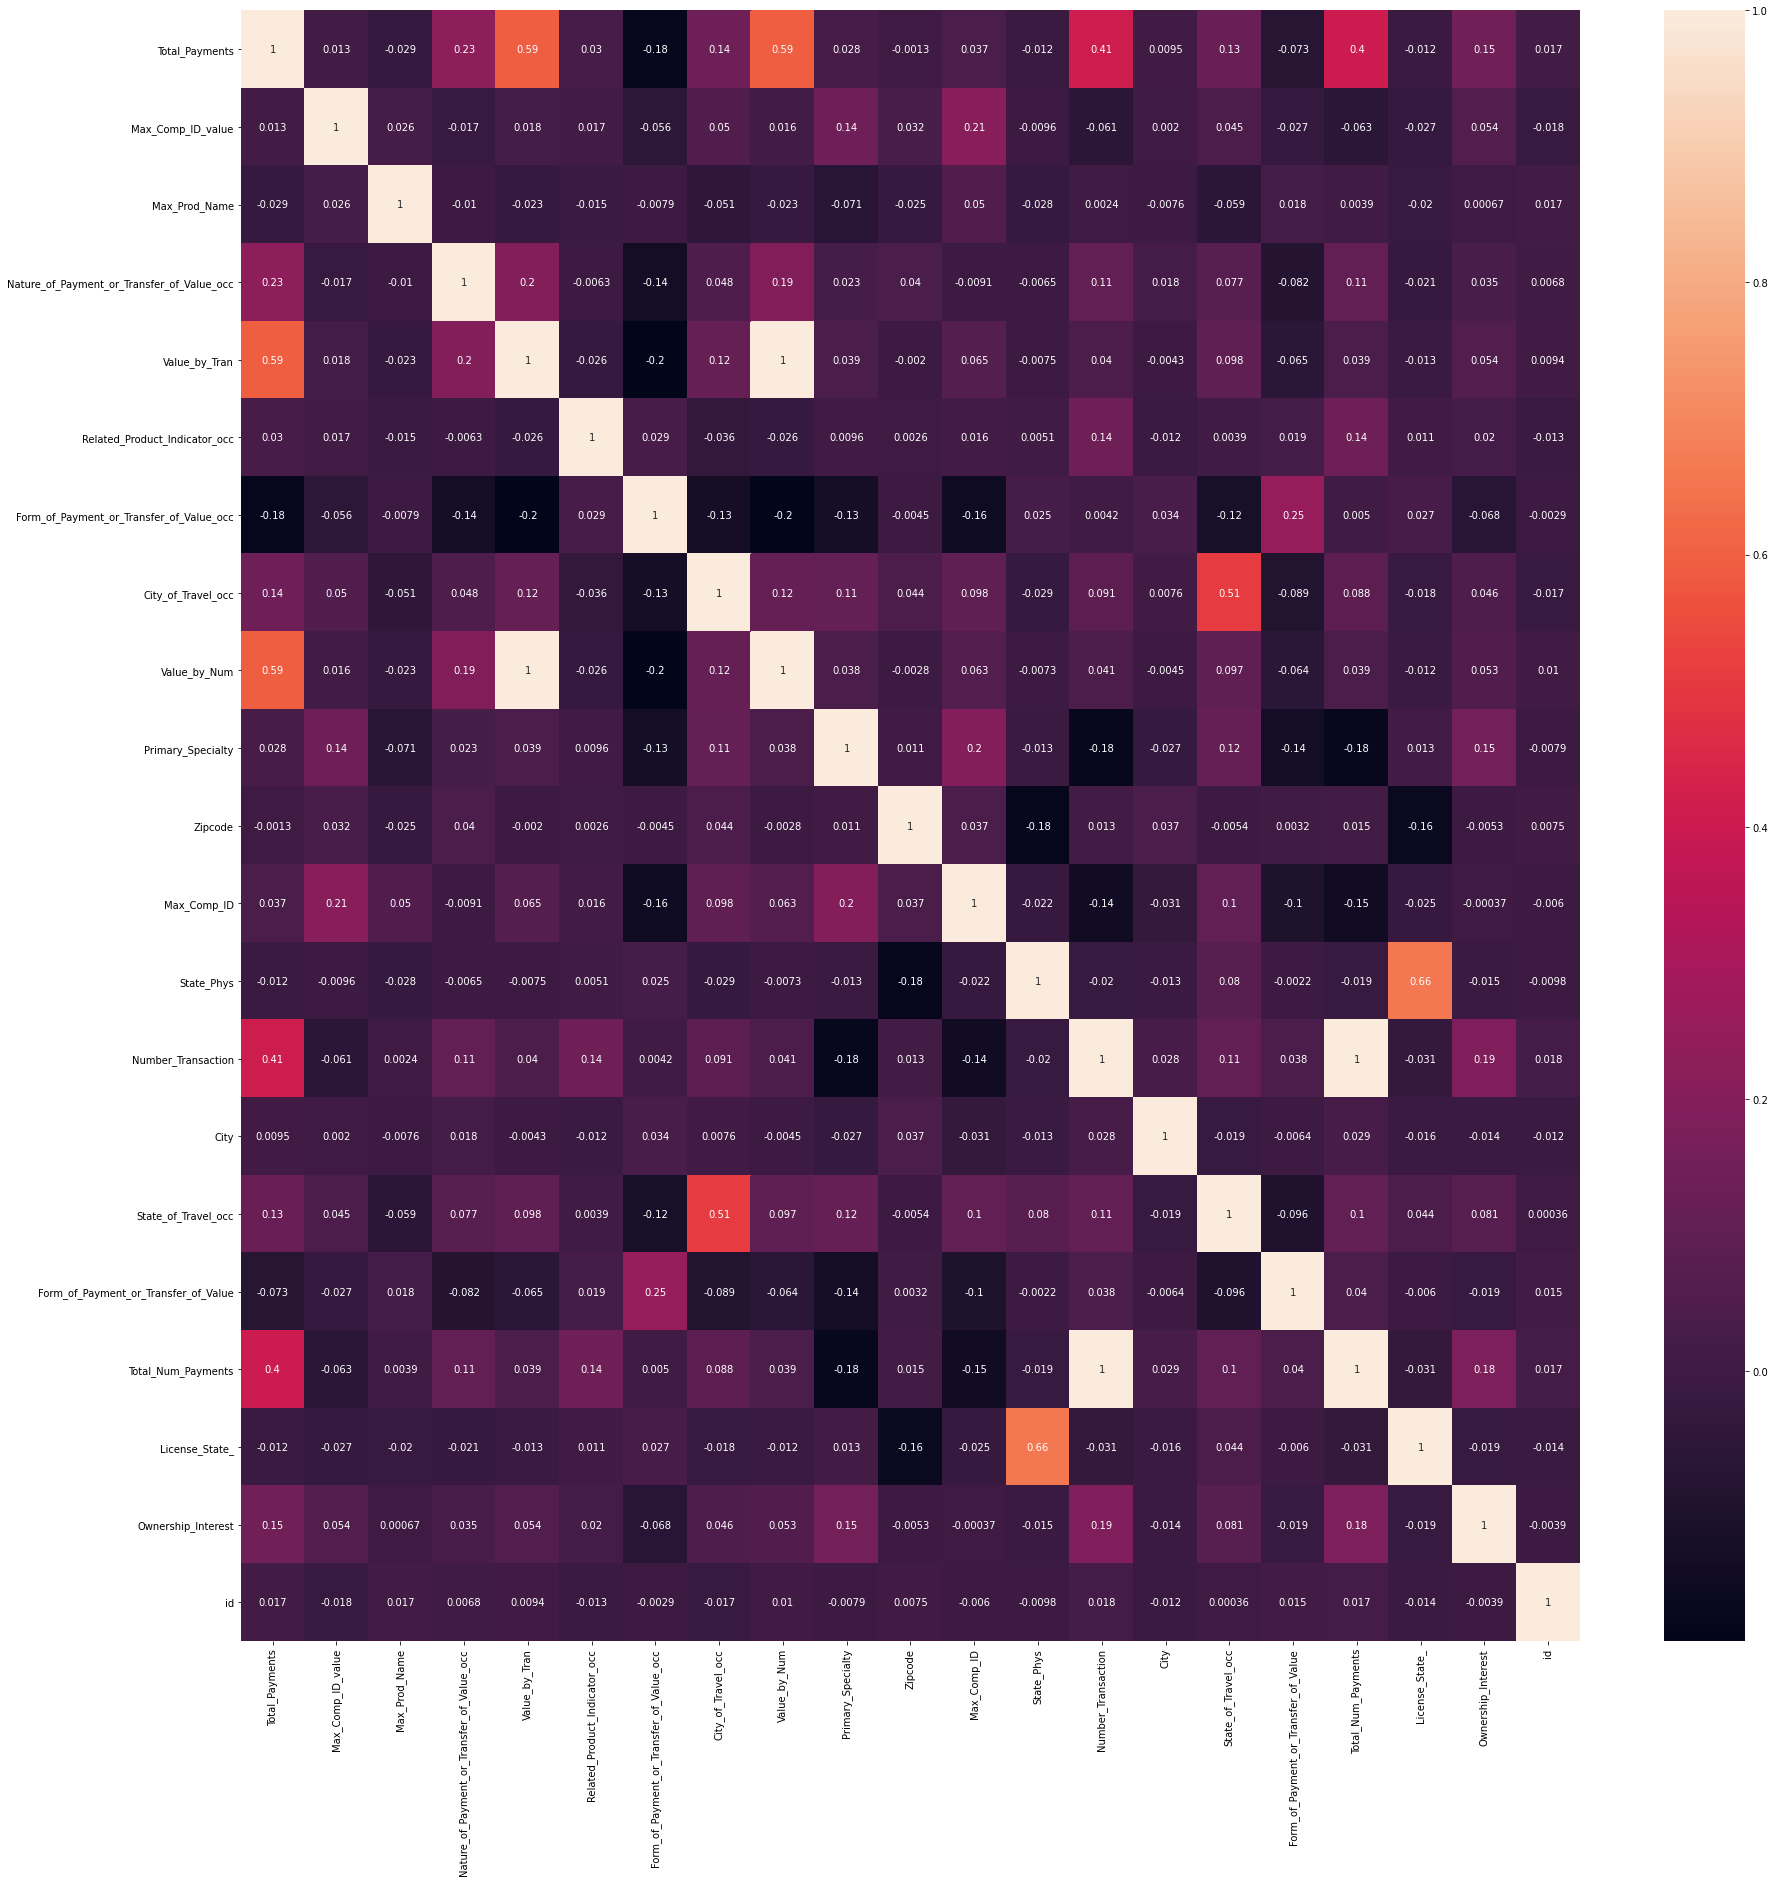

In [143]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
# df_train.drop(columns=['set'],inplace=True)

heatmap = sns.heatmap(df_train.corr(), annot=True)
fig = heatmap.get_figure()
fig.savefig("features_galore.png")

In [16]:
df_train=df[df.set=="train"]
df_test=df[df.set=="test"]


###drop set column
df_test.drop(columns=['set'],inplace=True)
df_train.drop(columns=['set'],inplace=True)

##send predicted attribute to end
first_col = df_train.pop("Ownership_Interest")
df_train.insert((df_train.shape[1]),"Ownership_Interest",first_col)

first_col = df_test.pop("Ownership_Interest")
df_test.insert((df_test.shape[1]),"Ownership_Interest",first_col)

##send Physician ID to end
first_col = df_train.pop("id")
df_train.insert((df_train.shape[1]),"id",first_col)

first_col = df_test.pop("id")
df_test.insert((df_test.shape[1]),"id",first_col)


c:\python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
np.random.seed(2021)
##downsampling
df_train_maj=df_train[df_train.Ownership_Interest==0]
df_train_min=df_train[df_train.Ownership_Interest==1]
df_train_maj_down=resample(df_train_maj, replace=False, n_samples=df_train_min.shape[0], random_state=2021)
df_train_final = pd.concat([df_train_maj_down, df_train_min])

#upsample
# df_train_maj=df_train[df_train.Ownership_Interest==0]
# df_train_min=df_train[df_train.Ownership_Interest==1]
# df_train_min_up=resample(df_train_min, replace=True, n_samples=600, random_state=2021)
# df_train_final = pd.concat([df_train_min_up, df_train_maj])

###test train split of own train set
df_train_final['is_train']=np.random.uniform(0,1,len(df_train_final)) <=.80
train, test = df_train_final[df_train_final['is_train']==True], df_train_final[df_train_final['is_train']==False]
train = shuffle(train,random_state=2021)
test = shuffle(test,random_state=2021)

In [18]:
print(df_train.columns)
df_train_final.Ownership_Interest.value_counts()

Index(['Nature_of_Payment_or_Transfer_of_Value_occ', 'Zipcode',
       'Nature_of_Payment_or_Transfer_of_Value', 'Max_Prod_Name', 'State_Phys',
       'State_of_Travel', 'Number_Transaction',
       'Form_of_Payment_or_Transfer_of_Value', 'Related_Product_Indicator',
       'Related_Product_Indicator_occ', 'Max_Prod_Name_value',
       'City_of_Travel', 'State_of_Travel_occ',
       'Form_of_Payment_or_Transfer_of_Value_occ', 'Value_by_Tran',
       'Max_Comp_ID', 'Max_Comp_ID_value', 'City', 'Value_by_Num',
       'Total_Payments', 'Total_Num_Payments', 'City_of_Travel_occ',
       'Primary_Specialty', 'License_State_', 'Ownership_Interest', 'id'],
      dtype='object')


1    533
0    533
Name: Ownership_Interest, dtype: int64

In [19]:
best=0
i=0
n=150
# f = open("AfterSqueezingNEstSearch.txt", "a")
# f.write("File Starts here:\n")

while n>0:
    n_est=r.randint(50,1500)
    min_samples_split=r.randint(2,10)
    min_samples_leaf=r.randint(1,5)
    i=r.randint(0,2)
    MFlist=['auto', 'sqrt', 'log2']
    sel_MF=MFlist[i]
    
    ###feature and label split
    features=train[train.columns[0:(train.shape[1]-3)]]
    y=train['Ownership_Interest']
    x_test = test[test.columns[0:(test.shape[1]-3)]]
    y_test = test['Ownership_Interest']

    ###model training
    clf = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators = n_est, random_state=2021,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,max_features=sel_MF)
    clf.fit(features, y)
    test_acc=clf.score(x_test,y_test)
    if test_acc>best:
        best=test_acc
#         f.write('BEST:'+' '+str(test_acc)+' N_EST: '+str(n_est)+'\n')
        print('BEST:'+' '+str(test_acc)+' N_EST: '+str(n_est)+'\n')
        print(clf.get_params())

BEST: 0.8088235294117647 N_EST: 136

BEST: 0.8186274509803921 N_EST: 176

BEST: 0.8284313725490197 N_EST: 60



KeyboardInterrupt: 

In [20]:
###feature and label split
features=train[train.columns[0:(train.shape[1]-3)]]
y=train['Ownership_Interest']
x_test = test[test.columns[0:(test.shape[1]-3)]]
y_test = test['Ownership_Interest']

###model training
clf = RandomForestClassifier(n_jobs=-1, oob_score = True, n_estimators = 60, random_state=2021)

clf.fit(features, y)

# Accuracy Scores
print ('Internal Accuracy Score', clf.oob_score_)
print ('RF accuracy: TRAINING', clf.score(features,y))
print ('RF accuracy: TESTING', clf.score(x_test,y_test))

preds = clf.predict(x_test)
print( pd.crosstab(y_test, preds, rownames=['Actual'], colnames=['Predicted']) )

# Feature Importance
feature_imp = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features.columns.values, clf.feature_importances_):
    feature_imp[feature] = importance


sorted(feature_imp.items(), key=itemgetter(1))

Internal Accuracy Score 0.7981438515081206
RF accuracy: TRAINING 1.0
RF accuracy: TESTING 0.8284313725490197
Predicted   0   1
Actual           
0          85  18
1          17  84


[('Nature_of_Payment_or_Transfer_of_Value', 0.0),
 ('State_of_Travel', 0.0),
 ('Related_Product_Indicator', 0.0),
 ('City_of_Travel', 0.0),
 ('Nature_of_Payment_or_Transfer_of_Value_occ', 0.0019613038636032173),
 ('Form_of_Payment_or_Transfer_of_Value_occ', 0.00636807944584289),
 ('Related_Product_Indicator_occ', 0.00894130735074202),
 ('Form_of_Payment_or_Transfer_of_Value', 0.009838027691170908),
 ('Max_Prod_Name_value', 0.02659576015737686),
 ('License_State_', 0.03195678327380437),
 ('City_of_Travel_occ', 0.03534854503547918),
 ('State_of_Travel_occ', 0.03710668012207723),
 ('State_Phys', 0.03901839905401248),
 ('Zipcode', 0.048539425769606875),
 ('Value_by_Tran', 0.056415943949233535),
 ('City', 0.05654472074887805),
 ('Max_Comp_ID_value', 0.057028204611836324),
 ('Value_by_Num', 0.06032534875888899),
 ('Max_Comp_ID', 0.0635470556182655),
 ('Max_Prod_Name', 0.06533430005888077),
 ('Total_Payments', 0.06675985533783095),
 ('Number_Transaction', 0.07164979843219682),
 ('Total_Num_Pa

In [22]:
# ['Value_by_Tran', 'Primary_Specialty', 'City', 'Total_Num_Payments',
#        'Number_Transaction', 'Zipcode', 'Value_by_Num', 'Total_Payments',
#        'Max_Comp_ID', 'Country_Phys', 'State_Phys', 'License_State_',
#        'Ownership_Interest', 'id'],


phys_id_list=df_test['id']
predict_set=df_test
predict_set.drop(columns=['id','Ownership_Interest'],inplace=True)
predict_set

c:\python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Nature_of_Payment_or_Transfer_of_Value_occ,Zipcode,Nature_of_Payment_or_Transfer_of_Value,Max_Prod_Name,State_Phys,State_of_Travel,Number_Transaction,Form_of_Payment_or_Transfer_of_Value,Related_Product_Indicator,Related_Product_Indicator_occ,Max_Prod_Name_value,City_of_Travel,State_of_Travel_occ,Form_of_Payment_or_Transfer_of_Value_occ,Value_by_Tran,Max_Comp_ID,Max_Comp_ID_value,City,Value_by_Num,Total_Payments,Total_Num_Payments,City_of_Travel_occ,Primary_Specialty,License_State_
13,3,2295,0,517,9,-1,539,1,0,4,80,-1,-1,1,10.715269,197,242,1547,10.636335,5775.53,543,-1,82,9
17,3,617,0,427,34,-1,584,1,0,4,-1,-1,13,1,157.745274,123,2285,1105,157.745274,92123.24,584,499,34,36
41,3,670,0,510,34,-1,180,1,0,4,-1,-1,-1,1,17.552722,190,271,184,17.552722,3159.49,180,-1,54,36
45,3,3135,0,11,22,-1,64,1,0,4,-1,-1,-1,1,25.224062,897,145,398,25.224062,1614.34,64,-1,-1,24
46,3,1181,0,427,20,-1,296,1,0,4,827,-1,-1,1,21.939189,123,47,127,21.939189,6494.00,296,-1,34,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27016,3,4742,0,1046,32,-1,139,0,0,4,736,-1,11,1,68.702662,675,550,19,68.702662,9549.67,139,92,78,51
27705,3,4298,0,294,44,-1,366,1,0,4,862,-1,41,1,31.814781,521,521,106,31.814781,11644.21,366,119,41,11
27810,3,1141,0,136,7,-1,47,0,0,4,-1,-1,18,0,79.403191,675,1142,1731,79.403191,3731.95,47,57,80,48
28447,3,4558,0,244,13,-1,75,1,0,4,777,-1,8,1,768.903200,911,911,425,768.903200,57667.74,75,6,70,15


In [23]:
score = clf.predict(predict_set)
submit={'Physician_ID':phys_id_list, 'Score':score}
submit_df=pd.DataFrame(data=submit)

In [24]:
scoreProb=clf.predict_proba(predict_set)
scoreProb_df=pd.DataFrame(data=scoreProb)

In [25]:
scoreProb_df.columns=['Prob_0','Prob_1']
scoreProb_df

,Prob_0,Prob_1
0,0.566667,0.433333
1,0.766667,0.233333
2,0.766667,0.233333
3,0.516667,0.483333
4,0.800000,0.200000
...,...,...
1471,0.433333,0.566667
1472,0.683333,0.316667
1473,0.583333,0.416667
1474,0.500000,0.500000


In [26]:
submit_df['Prob_0']=0
submit_df['Prob_1']=0
for i in range(submit_df.shape[0]):
    submit_df['Prob_0'].iloc[i]=scoreProb_df['Prob_0'].iloc[i]
    submit_df['Prob_1'].iloc[i]=scoreProb_df['Prob_1'].iloc[i]
    


c:\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [27]:

physIDLIST=submit_df.Physician_ID.unique()
scrapScore=[None]*1000
for i in range(physIDLIST.size):
    phys=physIDLIST[i]
    df_scrap=submit_df.query('Physician_ID==@phys')
    if(df_scrap.Score.nunique()>1):
        if(df_scrap.Prob_0.sum()>df_scrap.Prob_1.sum()):
            scrapScore[i]=0
        else:
            scrapScore[i]=1
    else:
        scrapScore[i]=df_scrap.Score.iloc[0]

finalDict={'id':physIDLIST, 'prediction':scrapScore}
finalSub=pd.DataFrame(data=finalDict)
    

In [28]:
finalSub.to_csv("./submission9.csv",index=False)

In [ ]:
submit_df.query('Physician_ID==2525')


In [ ]:
df_scrap = submit_df.drop(columns=['Prob_0','Prob_1'])
df_scrap.drop_duplicates(keep='first', inplace=True)
df_scrap.Physician_ID.value_counts()

In [31]:
inspect1=pd.read_csv("./submission9test.csv")
inspect2=pd.read_csv("./submission9.csv")
inspect1.sort_values('id')
dif=inspect2.prediction-inspect1.prediction
dif.value_counts()

 0    906
-1     58
 1     36
Name: prediction, dtype: int64